# Renalysis of Reimann2017
The full paper is available at https://www.mcponline.org/article/S1535-9476(20)32418-X/fulltext#figures

In [1]:
import os, sys

import numpy as np
import pandas as pd

sys.path.append('../..')

# noinspection PyUnresolvedReferences
from autoprot import analysis as ana
# noinspection PyUnresolvedReferences
from autoprot import preprocessing as pp
# noinspection PyUnresolvedReferences
from autoprot import visualization as vis

In [2]:
import zipfile

# Get a dict mapping the files matching the keyword (2nd arg) to their ftp download link
ftp_links = pp.fetch_from_pride("PXD004960", "MaxQuant_search_results")
# download the MaxQuant results if they are not present in the folder
if not os.path.isfile("./MaxQuant_search_results.zip"):
    pp.download_from_ftp(ftp_links["maxquant_search_results.zip"], save_dir=".")
archive = zipfile.ZipFile("./MaxQuant_search_results.zip", "r")
txt = archive.open("MaxQuant_search_results/combined/txt/proteinGroups.txt")

pg = pp.read_csv(txt)

Found file maxquant_search_results.zip


## Preprocessing

In [3]:
pg = pp.cleaning(pg, file="proteinGroups")

4330 rows before filter operation.
4171 rows after filter operation.


In [4]:
# New col with only the first gene name
pg["Gene names first"] = pg["Gene names"].str.split(";").str[0]

In [5]:
# this list is used to map the label switches
pg[pg["id"] == 5].filter(regex="Ratio .* normalized DM2").apply(np.log10)

,Ratio M/L normalized DM2,Ratio H/L normalized DM2,Ratio H/M normalized DM2
5,-0.009865,-0.025954,-0.019115


In [6]:
pg_ratios = pg.filter(regex="Ratio [H|M|L]/[H|M|L] DM").columns.to_list()
pg_ratios_norm = pg.filter(
    regex="Ratio [H|M|L]/[H|M|L] normalized DM"
).columns.to_list()

Mapping labels to replicates

| label | replicate | condition |
|-------|-----------|-----------|
| M/L   | DM1       | MT/MB     |
| H/L   | DM1       | MTP/MB    |
| H/M   | DM1       | MTP/MT    |
| -M/L  | DM2       | MTP/MB    |
| -H/L  | DM2       | MTP/MT    |
| H/M   | DM2       | MT/MB     |
| M/L   | DM3       | MTP/MT    |
| -H/L  | DM3       | MT/MB     |
| -H/M  | DM3       | MTP/MB    |

In [7]:
# ratios are inverted where the ratios have been inverted (indicated by - in table above)
pg, log_ratios_norm = pp.log(
    pg,
    pg_ratios_norm,
    base=10,
    invert=[1, 1, 1, -1, -1, 1, 1, -1, -1],
    return_cols=True,
)

In [8]:
# log transform intensities
intensity_cols = pg.filter(regex="Intensity DM\d+").columns

pg, log_intensity_cols = pp.log(
    pg, intensity_cols, base=10, invert=None, return_cols=True
)

In [9]:
# this adds the biological label to the respective isotope labels for better access during data analysis
conditions = [
    "MT/MB",
    "MTP/MB",
    "MTP/MT",
    "MTP/MB",
    "MTP/MT",
    "MT/MB",
    "MTP/MT",
    "MT/MB",
    "MTP/MB",
]

log_ratios_norm_explabel = [
    x + " " + cond for x, cond in zip(log_ratios_norm, conditions)
]

pg = pg.rename(
    columns={i: j for i, j in zip(log_ratios_norm, log_ratios_norm_explabel)}
)

## Comparing the replicates
We will use ratio vs. intensity plots to show the differences between the replicates for the different condition comparisons.

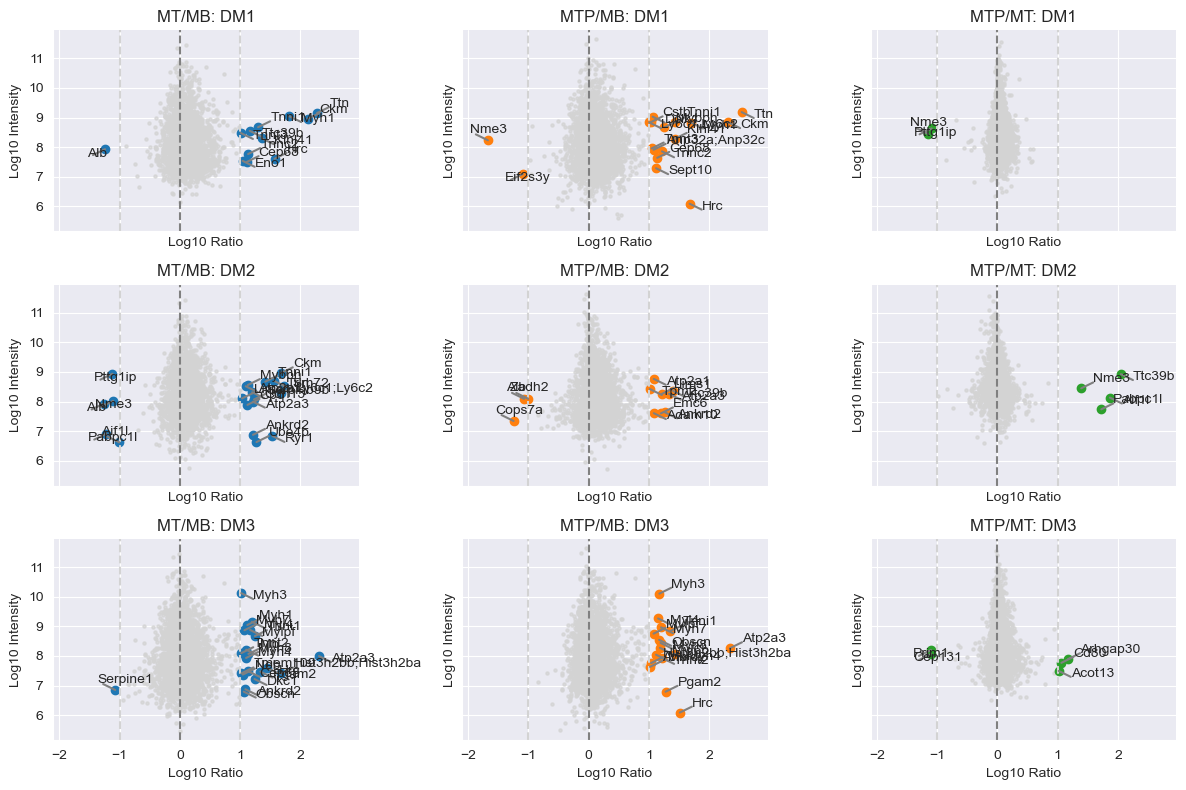

In [10]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(nrows=3, ncols=3, sharex="all", sharey="all", figsize=(12, 8))

mycolors = [x[1] for x in mcolors.TABLEAU_COLORS.items()]

# plot ratio plots for each replicate
for idx, exp in enumerate(["MT/MB", "MTP/MB", "MTP/MT"]):
    for jdx, rep in enumerate(["DM1", "DM2", "DM3"]):
        for log_fc in [
            x for x in log_ratios_norm_explabel if (exp in x) and (rep in x)
        ]:
            # this ignores errors with values <= 0 in log calculation
            with np.errstate(invalid="ignore"):
                # normalised values are plotted on top of the non-normalised values for comparison
                vis.log_int_plot(
                    pg,
                    log_fc=log_fc,
                    log_intens_col=log_intensity_cols[idx],
                    ax=axs[jdx][idx],
                    fct=np.log10(10),
                    legend=False,
                    sig_col=mycolors[idx],
                    annot="Gene names",
                    title=f"{exp}: {rep}",
                )
        axs[jdx][idx].title.set_size(12)
        axs[jdx][idx].yaxis.label.set_size(10)
        axs[jdx][idx].xaxis.label.set_size(10)
        axs[jdx][idx].set_xlabel("Log10 Ratio")
        axs[jdx][idx].set_ylabel("Log10 Intensity")
plt.tight_layout()

## Statistical analysis and volcano plot

The three replicates for each comparison enable not only to calculate mean normalized ratios but also to statistically infer if changes between conditions were singnificant.

In [11]:
# group the labels in replicates
grouped_log_ratios_norm_explabel = [
    [x for x in log_ratios_norm_explabel if "MT/MB" in x],
    [x for x in log_ratios_norm_explabel if "MTP/MB" in x],
    [x for x in log_ratios_norm_explabel if "MTP/MT" in x],
]

grouped_log_ratios_norm_explabel

[['log10_Ratio M/L normalized DM1 MT/MB',
  'log10_Ratio H/M normalized DM2 MT/MB',
  'log10_Ratio L/H normalized DM3 MT/MB'],
 ['log10_Ratio H/L normalized DM1 MTP/MB',
  'log10_Ratio L/M normalized DM2 MTP/MB',
  'log10_Ratio M/H normalized DM3 MTP/MB'],
 ['log10_Ratio H/M normalized DM1 MTP/MT',
  'log10_Ratio L/H normalized DM2 MTP/MT',
  'log10_Ratio M/L normalized DM3 MTP/MT']]

In [12]:
# filter by valid values
pg = pp.filter_vv(pg, grouped_log_ratios_norm_explabel)

4171 rows before filter operation.
2573 rows after filter operation.


In [13]:
# calculate p valhues directly based on the pairwise ratios
for reps, cond in zip(
    grouped_log_ratios_norm_explabel,
    ["_MT/MB_ttest", "_MTP/MB_ttest", "_MTP/MT_ttest"],
):
    pg = ana.ttest(pg, reps, cond=cond)

Performing one-sample t-Test
Performing one-sample t-Test
Performing one-sample t-Test


In [14]:
# infer the effect of MTP/MT from the other two conditions
for coef, cond in zip(
    ["MTvsMB", "MTPvsMB", "MTPvsMB-MTvsMB"],
    ["_MT/MB_design", "_MTP/MB_design", "_MTP/MT_design"],
):
    pg = ana.limma(
        pg,
        grouped_log_ratios_norm_explabel,
        custom_design="04_design.tsv",
        coef=coef,
        cond=cond,
    )

LIMMA: Assuming a custom design test with:
Design specified at 04_design.tsv
Columns: log10_Ratio M/L normalized DM1 MT/MB
	log10_Ratio H/M normalized DM2 MT/MB
	log10_Ratio L/H normalized DM3 MT/MB
	log10_Ratio H/L normalized DM1 MTP/MB
	log10_Ratio L/M normalized DM2 MTP/MB
	log10_Ratio M/H normalized DM3 MTP/MB
	log10_Ratio H/M normalized DM1 MTP/MT
	log10_Ratio L/H normalized DM2 MTP/MT
	log10_Ratio M/L normalized DM3 MTP/MT
Using design matrix:

|    |   MTvsMB |   MTPvsMB |   H |   M |
|---:|---------:|----------:|----:|----:|
|  0 |        1 |         0 |   0 |   1 |
|  1 |        1 |         0 |   1 |  -1 |
|  2 |        1 |         0 |  -1 |   0 |
|  3 |        0 |         1 |   1 |   0 |
|  4 |        0 |         1 |   0 |  -1 |
|  5 |        0 |         1 |  -1 |   1 |
|  6 |       -1 |         1 |   1 |  -1 |
|  7 |       -1 |         1 |  -1 |   0 |
|  8 |       -1 |         1 |   0 |   1 |
LIMMA: Assuming a custom design test with:
Design specified at 04_design.tsv
Column

In [15]:
# Load the original cluster annotation
cluster_annot = pd.read_excel(
    "04_mcp.M116.065425-3.xlsx", sheet_name="proteins", skiprows=2
)

cluster_annot = cluster_annot.loc[:, ~cluster_annot.columns.str.contains("^Unnamed")]

cluster_annot = cluster_annot.loc[
    cluster_annot["Cluster"].notnull(), ["Protein group ID", "Cluster"]
]

cluster_annot["Cluster"] = cluster_annot["Cluster"].astype(int)

cluster_annot.rename({"Cluster": "Original cluster"}, inplace=True, axis=1)

cluster_annot

,Protein group ID,Original cluster
0,0,6
5,5,8
7,7,7
8,8,7
9,9,1
...,...,...
4210,4323,3
4211,4324,7
4212,4325,3
4215,4328,5


In [16]:
# merge the original cluster ID into the pg dataframe
pg = pd.merge(pg, cluster_annot, left_on="id", right_on="Protein group ID")

Not enough data points for KDE. Return original point cloud.
Not enough data points for KDE. Return original point cloud.


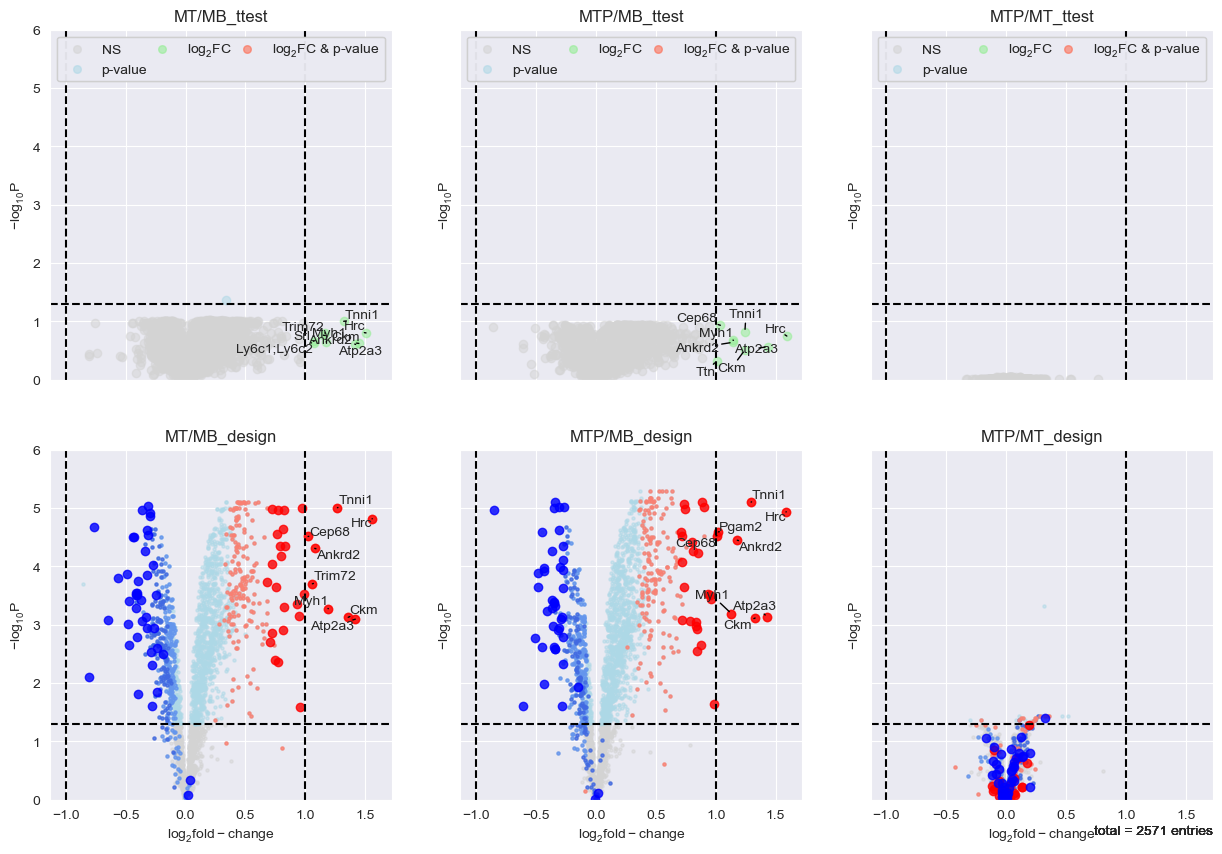

In [17]:
fig, axs = plt.subplots(nrows=2, ncols=3, sharex="all", sharey="all", figsize=(15, 10))

mycolors = [x[1] for x in mcolors.TABLEAU_COLORS.items()]

cluster1 = pg[pg["Original cluster"] == 1].index
cluster2 = pg[pg["Original cluster"] == 2].index
cluster11 = pg[pg["Original cluster"] == 11].index
cluster10 = pg[pg["Original cluster"] == 10].index
cluster9 = pg[pg["Original cluster"] == 9].index

# plot ratio plots for each replicate
for idx, exp in enumerate(["MT/MB_ttest", "MTP/MB_ttest", "MTP/MT_ttest"]):
    vis.volcano(
        pg,
        log_fc_colname=pg.filter(regex=f"logFC_{exp}").columns.to_list()[0],
        p_colname=pg.filter(regex=f"adj.pValue_{exp}").columns.to_list()[0],
        ax=axs[0][idx],
        annotate="log2FC",
    )

    axs[0][idx].set_ylim((0, 6))
    axs[0][idx].set_title(exp)
    axs[0][idx].set_xlabel(None)

# plot ratio plots for each replicate
for idx, exp in enumerate(["MT/MB_design", "MTP/MB_design", "MTP/MT_design"]):
    vis.volcano(
        pg,
        log_fc_colname=pg.filter(regex=f"logFC_{exp}").columns.to_list()[0],
        p_colname=pg.filter(regex=f"adj.P.Val_{exp}").columns.to_list()[0],
        ax=axs[1][idx],
        show_legend=False,
        highlight=[cluster9, cluster10, cluster2, cluster1, cluster11],
        kwargs_highlight=[
            {"color": "cornflowerblue", "s": 5},
            {"color": "royalblue", "s": 5},
            {"color": "salmon", "s": 5},
            {"color": "red"},
            {"color": "blue"},
        ],
        kwargs_p_sig={"color": "lightblue", "s": 5},
        kwargs_ns={"s": 5},
    )

    axs[1][idx].set_title(exp)

# Clustering
In the original paper, the authors clustered directly with raw ratios. Here we will use p-values from the LIMMA test to do the same.
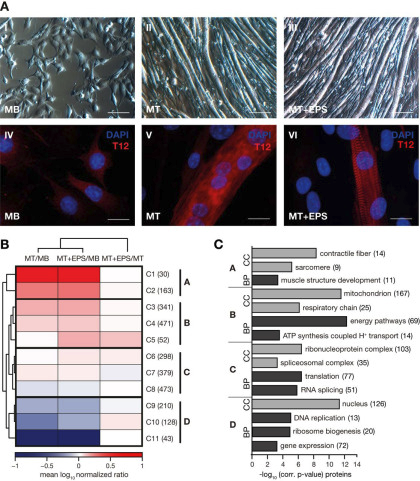

In [18]:
import pandas as pd

log_ratio = pg.filter(regex="logFC_.*_design")

log_ratio = log_ratio.dropna(how="any")

log_ratio.sort_values(by="logFC_MTP/MB_design", inplace=True)

log_ratio

,logFC_MT/MB_design,logFC_MTP/MB_design,logFC_MTP/MT_design
803,-0.765869,-0.847726,-0.081857
715,-0.808223,-0.610518,0.197705
110,-0.471833,-0.506669,-0.034836
396,-0.492382,-0.482985,0.009398
1060,-0.562712,-0.480110,0.082602
...,...,...,...
2521,1.078104,1.180264,0.102160
245,1.267593,1.295562,0.027968
146,1.357483,1.328958,-0.028526
174,1.416701,1.431249,0.014547


In [19]:
c = ana.clustering.KMeans(log_ratio)
c.cmap = "coolwarm"
c.nclusters = 11
c.make_cluster(algo='sklearn', random_state=42)

Removed 0 NaN values from the dataframe to prepare for clustering.


C:\Users\jub29yk\Anaconda3\envs\autoprot\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(


In [20]:
## Rename the clusters so that the biggest cluster is #1
unique_elements, counts_elements = np.unique(c.clusterId, return_counts=True)
cluster_id_copy = newArray = np.copy(c.clusterId)

count_sort_ind = np.argsort(-counts_elements)

# biggest to smallest
d = {
    old: new
    for old, new in zip(
        unique_elements[count_sort_ind], range(1, len(unique_elements) + 1)
    )
}

for k, v in d.items():
    cluster_id_copy[c.clusterId == k] = v

c.clusterId = cluster_id_copy

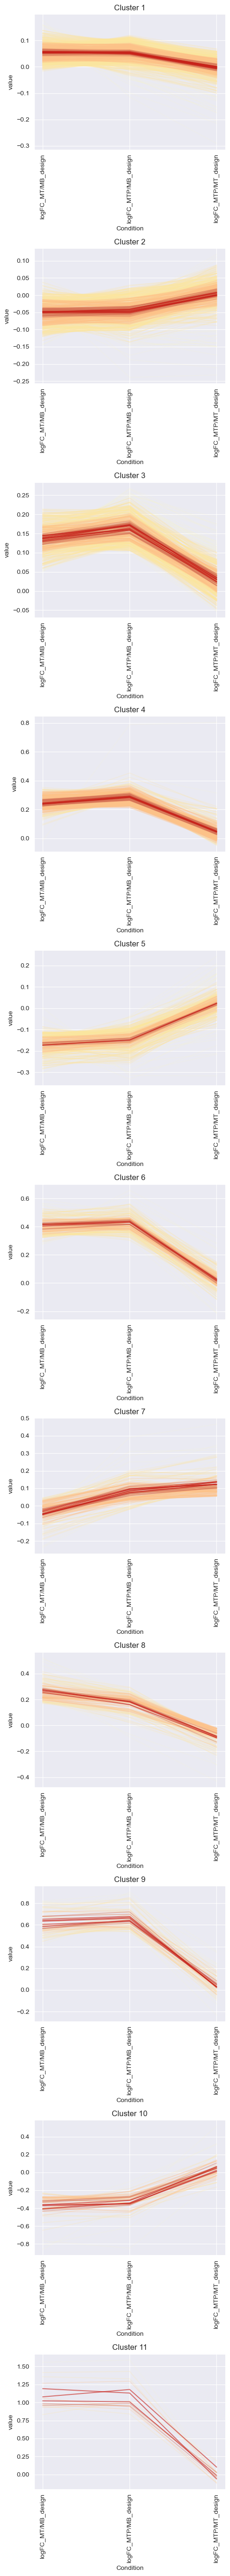

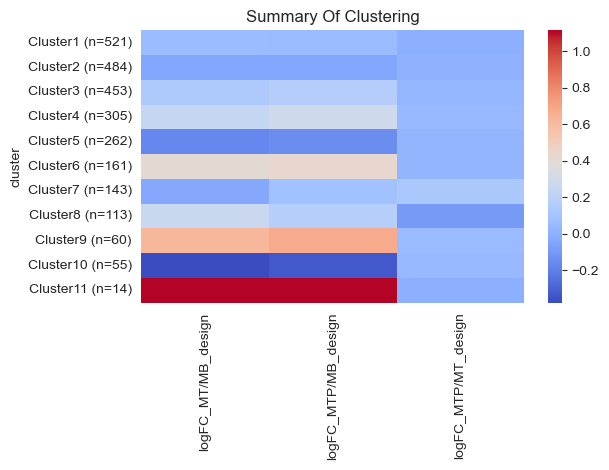

In [21]:
traces, heatmap = c.vis_cluster(
    make_traces=True,
    make_heatmap=True,
    make_clustermap=False,
    col_cluster=True,
    ret_figs=True,
)

In [22]:
log_ratio["New cluster"] = c.clusterId

clustering = pd.merge(
    log_ratio,
    pg[["Gene names", "id", "Protein names"]],
    left_index=True,
    right_index=True,
)

clustering

,logFC_MT/MB_design,logFC_MTP/MB_design,logFC_MTP/MT_design,New cluster,Gene names,id,Protein names
803,-0.765869,-0.847726,-0.081857,10,Cyr61,1543,Protein CYR61
715,-0.808223,-0.610518,0.197705,10,Alb,1442,Serum albumin
110,-0.471833,-0.506669,-0.034836,10,Mrto4,235,mRNA turnover protein 4 homolog
396,-0.492382,-0.482985,0.009398,10,Bcat1,865,Branched-chain-amino-acid aminotransferase;Bra...
1060,-0.562712,-0.480110,0.082602,10,Cks1brt;Cks1b,1885,Cyclin-dependent kinases regulatory subunit;Cy...
...,...,...,...,...,...,...,...
2521,1.078104,1.180264,0.102160,11,Ankrd2,4209,Ankyrin repeat domain-containing protein 2
245,1.267593,1.295562,0.027968,11,Tnni1,549,"Troponin I, slow skeletal muscle"
146,1.357483,1.328958,-0.028526,11,Ckm,300,Creatine kinase M-type
174,1.416701,1.431249,0.014547,11,Atp2a3,357,Calcium-transporting ATPase;Sarcoplasmic/endop...


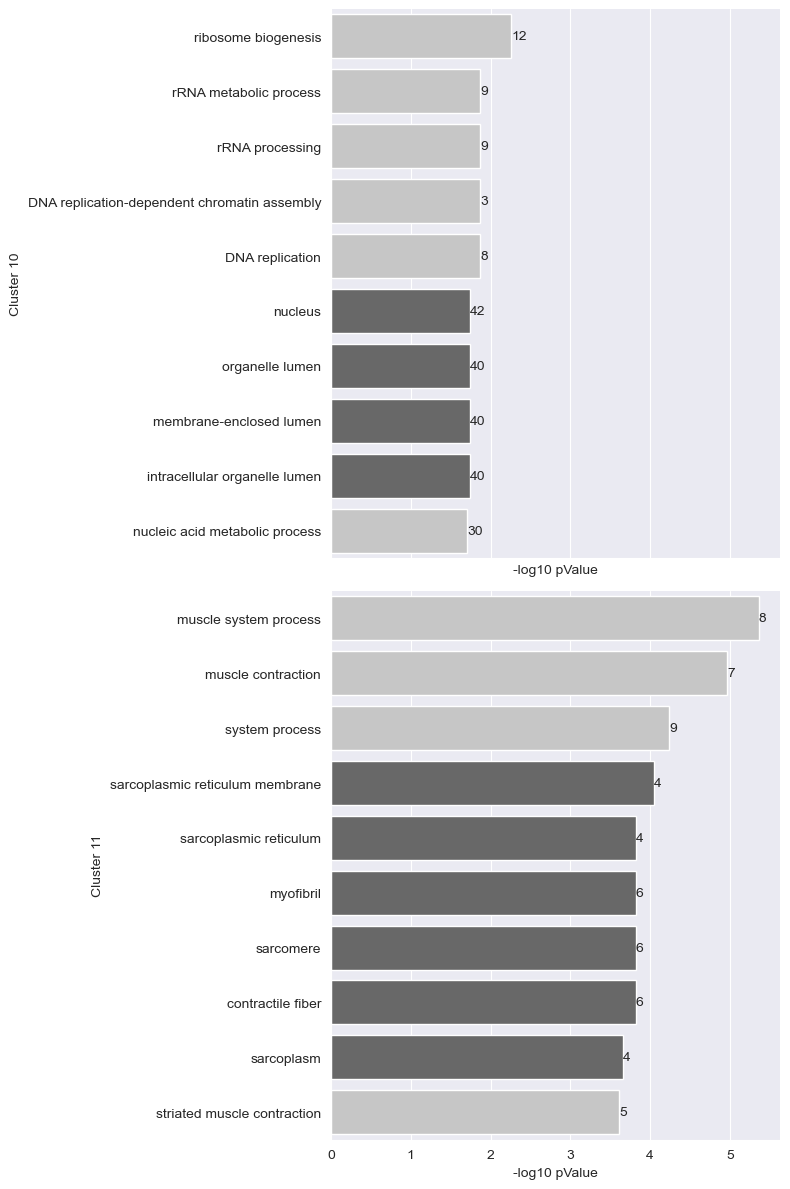

In [23]:
import seaborn as sns

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 12), sharex="all")

background = [
    x.split(";")[0].upper() for x in clustering["Gene names"].dropna().to_list()
]

for ax, cluster in zip(axs, range(10, 12)):
    gene_names = [
        x.split(";")[0].upper()
        for x in clustering.loc[clustering["New cluster"] == cluster, "Gene names"]
        .dropna()
        .to_list()
    ]

    result = ana.go_analysis(
        gene_list=gene_names,
        organism="hsapiens",
        background=background,
        significance_threshold_method="fdr",
    )

    result = result.loc[
        (result["p_value"] < 0.05)  # significant by p-value
        & (
            (result["source"] == "GO:CC") | (result["source"] == "GO:BP")
        ),  # either BP or CC
        :,
    ]

    result["-log10 pValue"] = -np.log10(result["p_value"])

    # take top 10
    result = result.sort_values(by="-log10 pValue", ascending=False).head(10)

    sns.barplot(
        y=result["name"],
        x=result["-log10 pValue"],
        hue=result["source"],
        palette="Greys",
        ax=ax,
        dodge=False,
    )

    for container in ax.containers:
        ax.bar_label(container, labels=result["intersection_size"])

    ax.set_ylabel(f"Cluster {cluster}")
    ax.get_legend().remove()
    sns.despine()

plt.tight_layout()

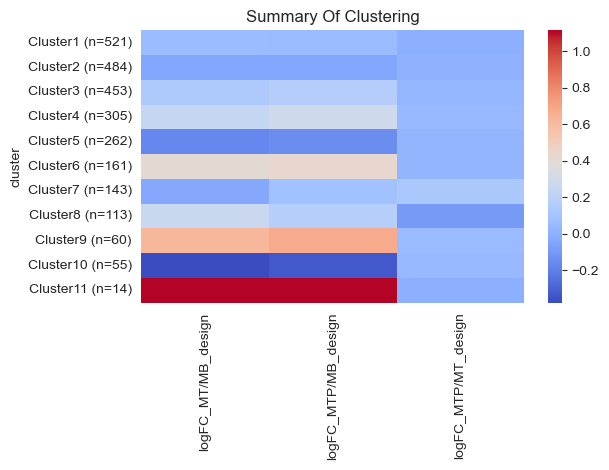

In [24]:
heatmap

In [25]:
# add the new clustering information
pg = pd.merge(pg, clustering[["id", "New cluster"]], left_on="id", right_on="id")

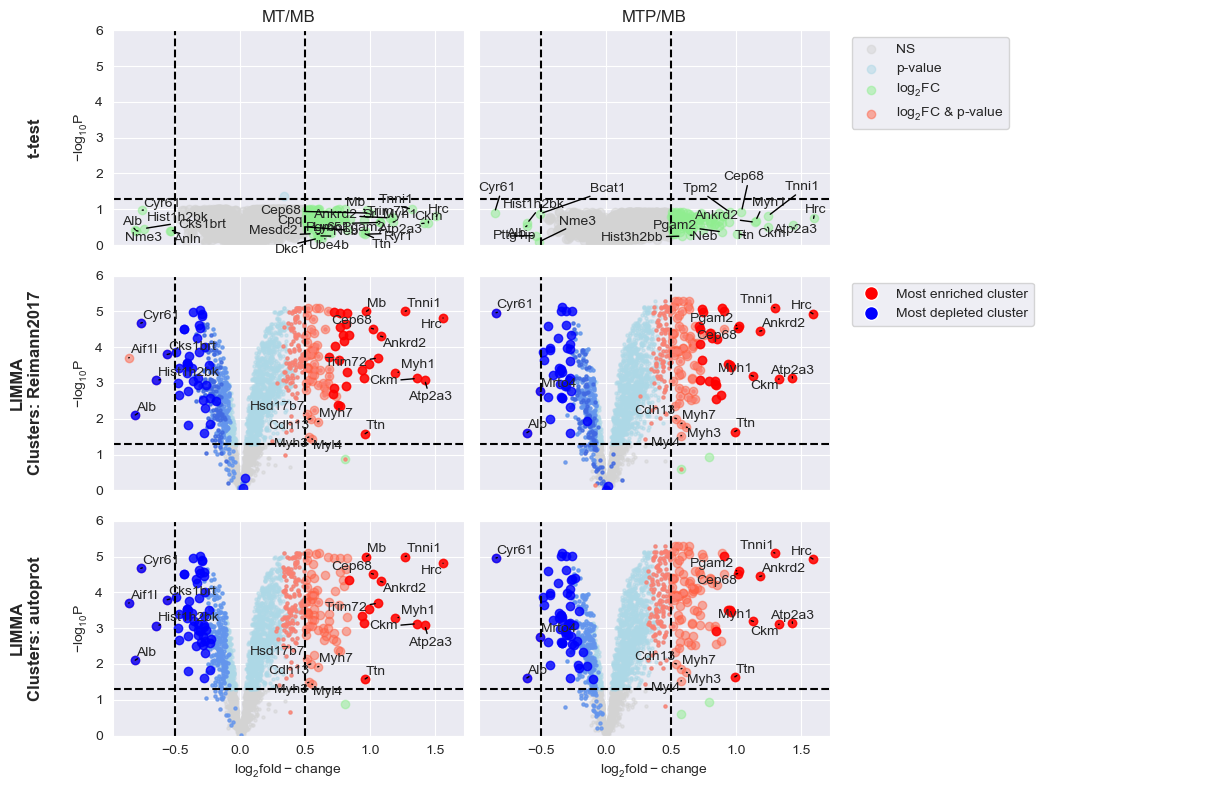

In [29]:
from matplotlib.lines import Line2D

yfig, axs = plt.subplots(nrows=3, ncols=3, sharex="all", sharey="all", figsize=(12, 8))

mycolors = [x[1] for x in mcolors.TABLEAU_COLORS.items()]

cluster1 = pg[pg["Original cluster"] == 1].index
cluster2 = pg[pg["Original cluster"] == 2].index
cluster11 = pg[pg["Original cluster"] == 11].index
cluster10 = pg[pg["Original cluster"] == 10].index
cluster9 = pg[pg["Original cluster"] == 9].index

new_cluster10 = pg[pg["New cluster"] == 10].index
new_cluster6 = pg[pg["New cluster"] == 6].index
new_cluster11 = pg[pg["New cluster"] == 11].index
new_cluster7 = pg[pg["New cluster"] == 7].index
new_cluster5 = pg[pg["New cluster"] == 5].index

# plot ratio plots for each replicate
for idx, exp in enumerate(["MT/MB_ttest", "MTP/MB_ttest"]):
    vis.volcano(
        pg,
        log_fc_colname=pg.filter(regex=f"logFC_{exp}").columns.to_list()[0],
        p_colname=pg.filter(regex=f"adj.pValue_{exp}").columns.to_list()[0],
        show_legend=False,
        show_caption=False,
        ax=axs[0][idx],
        annotate="log2FC",
        log_fc_thresh=0.5,
        annotate_colname="Gene names first",
    )

    axs[0][idx].set_ylim((0, 6))
    axs[0][idx].set_title(exp[:-6])
    axs[0][idx].set_xlabel(None)
    if idx != 0:
        axs[0][idx].set_ylabel(None)

# get the legend handles from the actual plot
handles, labels = axs[0, 1].get_legend_handles_labels()
# remove the spines on the rightmost subplot
axs[0, 2].set_axis_off()
# add the legend to the rightmost subplot
axs[0, 2].legend(handles, labels, loc="upper left")

# text indicating the analysis condition
axs[0, 0].text(
    -0.2,
    0.5,
    "t-test",
    rotation=90,
    transform=axs[0, 0].transAxes,
    fontsize=12,
    weight="bold",
    horizontalalignment="right",
    verticalalignment="center",
    ma="center",
)

# plot ratio plots for each replicate
for idx, exp in enumerate(["MT/MB_design", "MTP/MB_design"]):
    vis.volcano(
        pg,
        log_fc_colname=pg.filter(regex=f"logFC_{exp}").columns.to_list()[0],
        p_colname=pg.filter(regex=f"adj.P.Val_{exp}").columns.to_list()[0],
        ax=axs[1][idx],
        show_legend=False,
        show_caption=False,
        log_fc_thresh=0.5,
        annotate_colname="Gene names first",
        highlight=[cluster9, cluster10, cluster2, cluster1, cluster11],
        kwargs_highlight=[
            {"color": "cornflowerblue", "s": 5},
            {"color": "royalblue", "s": 5},
            {"color": "salmon", "s": 5},
            {"color": "red"},
            {"color": "blue"},
        ],
        kwargs_p_sig={"color": "lightblue", "s": 5},
        kwargs_ns={"s": 5},
    )

    axs[1][idx].set_xlabel(None)
    if idx != 0:
        axs[1][idx].set_ylabel(None)

# remove the spines on the rightmost subplot
axs[1, 2].set_axis_off()

# generate dummy data for manual legend
common_args = {
    "xdata": [0],
    "ydata": [0],
    "marker": "o",
    "linestyle": "none",
    "markersize": 10,
    "color": "white",
}

red_circle = (Line2D(**common_args, markerfacecolor="red"),)

blue_circle = (
    Line2D(
        **common_args,
        markerfacecolor="blue",
    ),
)

# add the legend to the rightmost subplot
axs[1, 2].legend(
    (red_circle, blue_circle),
    ("Most enriched cluster", "Most depleted cluster"),
    loc="upper left",
)


# text indicating the analysis condition
axs[1, 0].text(
    -0.2,
    0.5,
    "LIMMA\nClusters: Reimann2017",
    rotation=90,
    transform=axs[1, 0].transAxes,
    fontsize=12,
    weight="bold",
    horizontalalignment="right",
    verticalalignment="center",
    ma="center",
)

# plot ratio plots for each replicate
for idx, exp in enumerate(["MT/MB_design", "MTP/MB_design"]):
    vis.volcano(
        pg,
        log_fc_colname=pg.filter(regex=f"logFC_{exp}").columns.to_list()[0],
        p_colname=pg.filter(regex=f"adj.P.Val_{exp}").columns.to_list()[0],
        ax=axs[2][idx],
        show_legend=False,
        log_fc_thresh=0.5,
        annotate_colname="Gene names first",
        show_caption=False,
        highlight=[
            new_cluster5,
            new_cluster6,
            new_cluster11,
            new_cluster10,
        ],
        kwargs_highlight=[
            {"color": "cornflowerblue", "s": 5},
            {"color": "salmon", "s": 5},
            {"color": "red"},
            {"color": "blue"},
        ],
        kwargs_p_sig={"color": "lightblue", "s": 5},
        kwargs_ns={"s": 5},
    )

    if idx != 0:
        axs[2][idx].set_ylabel(None)

axs[2, 2].set_axis_off()

# text indicating the analysis condition
axs[2, 0].text(
    -0.2,
    0.5,
    "LIMMA\nClusters: autoprot",
    rotation=90,
    transform=axs[2, 0].transAxes,
    fontsize=12,
    weight="bold",
    horizontalalignment="right",
    verticalalignment="center",
    ma="center",
)

plt.tight_layout()